### Load Experiment

In [61]:
import matplotlib.pyplot as plt
import importlib
import json
import os
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
from typing import Optional

import ray
import typer
import yaml
from ray.rllib.common import CLIArguments as cli
from ray.rllib.common import SupportedFileType
from ray.rllib.common import _download_example_file, _get_file_type
from ray.tune.registry import register_trainable
from ray.tune.resources import resources_to_json, json_to_resources
from ray.tune.schedulers import create_scheduler
from ray.tune.tune import run_experiments

In [5]:
#!/usr/bin/env python
def _register_all():
    from blades.algorithms.registry import ALGORITHMS, _get_algorithm_class

    for key, get_trainable_class_and_config in ALGORITHMS.items():
        register_trainable(key, get_trainable_class_and_config()[0])
    for key in ["__fake", "__sigmoid_fake_data", "__parameter_tuning"]:
        register_trainable(key, _get_algorithm_class(key))

_register_all()

def load_experiments_from_file(
    config_file: str,
    file_type: SupportedFileType,
    stop: Optional[str] = None,
    checkpoint_config: Optional[dict] = None,
) -> dict:
    """Load experiments from a file. Supports YAML and Python files.

    If you want to use a Python file, it has to have a 'config' variable
    that is an AlgorithmConfig object and - optionally - a `stop` variable defining
    the stop criteria.

    Args:
        config_file: The yaml or python file to be used as experiment definition.
            Must only contain exactly one experiment.
        file_type: One value of the `SupportedFileType` enum (yaml or python).
        stop: An optional stop json string, only used if file_type is python.
            If None (and file_type is python), will try to extract stop information
            from a defined `stop` variable in the python file, otherwise, will use {}.
        checkpoint_config: An optional checkpoint config to add to the returned
            experiments dict.

    Returns:
        The experiments dict ready to be passed into `tune.run_experiments()`.
    """

    # Yaml file.
    if file_type == SupportedFileType.yaml:
        with open(config_file) as f:
            experiments = yaml.safe_load(f)
            if stop is not None and stop != "{}":
                raise ValueError("`stop` criteria only supported for python files.")
    # Python file case (ensured by file type enum)
    else:
        module_name = os.path.basename(config_file).replace(".py", "")
        spec = importlib.util.spec_from_file_location(module_name, config_file)
        module = importlib.util.module_from_spec(spec)
        sys.modules[module_name] = module
        spec.loader.exec_module(module)

        if not hasattr(module, "config"):
            raise ValueError(
                "Your Python file must contain a 'config' variable "
                "that is an AlgorithmConfig object."
            )
        algo_config = getattr(module, "config")
        if stop is None:
            stop = getattr(module, "stop", {})
        else:
            stop = json.loads(stop)

        # Note: we do this gymnastics to support the old format that
        # "run_fedlib_experiments" expects. Ideally, we'd just build the config and
        # run the algo.
        config = algo_config.to_dict()
        experiments = {
            "default": {
                "run": algo_config.__class__.__name__.replace("Config", ""),
                "env": config.get("env"),
                "config": config,
                "stop": stop,
            }
        }

    for key, _ in experiments.items():
        experiments[key]["checkpoint_config"] = checkpoint_config or {}
    return experiments

def file(
    # File-based arguments.
    config_file: str = cli.ConfigFile,
    # stopping conditions
    stop: Optional[str] = cli.Stop,
    # Checkpointing
    checkpoint_freq: int = cli.CheckpointFreq,
    checkpoint_at_end: bool = cli.CheckpointAtEnd,
    keep_checkpoints_num: int = cli.KeepCheckpointsNum,
    checkpoint_score_attr: str = cli.CheckpointScoreAttr,
    # Additional config arguments used for overriding.
    v: bool = cli.V,
    vv: bool = cli.VV,
    trace: bool = cli.Trace,
    # WandB options.
    wandb_key: Optional[str] = cli.WandBKey,
    wandb_project: Optional[str] = cli.WandBProject,
    wandb_run_name: Optional[str] = cli.WandBRunName,
    # Ray cluster options.
    local_mode: bool = cli.LocalMode,
    ray_address: Optional[str] = cli.RayAddress,
    ray_ui: bool = cli.RayUi,
    ray_num_cpus: Optional[int] = cli.RayNumCpus,
    ray_num_gpus: Optional[int] = cli.RayNumGpus,
    ray_num_nodes: Optional[int] = cli.RayNumNodes,
    ray_object_store_memory: Optional[int] = cli.RayObjectStoreMemory,
    # Ray scheduling options.
    resume: bool = cli.Resume,
    scheduler: Optional[str] = cli.Scheduler,
    scheduler_config: str = cli.SchedulerConfig,
):
    """Train a reinforcement learning agent from file. The file argument is
    required to run this command.\n\n.

    Grid search example with the RLlib CLI:\n
      rllib train file tuned_examples/ppo/cartpole-ppo.yaml\n\n

    You can also run an example from a URL with the file content:\n
      rllib train file https://raw.githubusercontent.com/ray-project/ray/\
      master/rllib/tuned_examples/ppo/cartpole-ppo.yaml
    """
    # Attempt to download the file if it's not found locally.
    config_file, temp_file = _download_example_file(
        example_file=config_file, base_url=None
    )

    checkpoint_config = {
        "checkpoint_frequency": checkpoint_freq,
        "checkpoint_at_end": checkpoint_at_end,
        "num_to_keep": keep_checkpoints_num,
        "checkpoint_score_attribute": checkpoint_score_attr,
    }

    file_type = _get_file_type(config_file)

    experiments = load_experiments_from_file(
        config_file, file_type, stop, checkpoint_config
    )
    exp_name = list(experiments.keys())[0]
    algo = experiments[exp_name]["run"]

    # WandB logging support.
    callbacks = None
    # if we had to download the config file, remove the temp file.
    if temp_file:
        temp_file.close()

    return experiments

### Point to Experiment Config

In [11]:
experiments = file("blades/tuned_examples/fedsgd_cnn_fashion_mnist.yaml", None)
for key, _ in experiments.items():
    experiments[key]["checkpoint_config"] = {}

In [20]:
trials = run_experiments(
    experiments,
    resume=True,
    verbose=True,
    concurrent=False
)

2025-04-21 20:21:07,912	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-04-15_20-43-52.json
2025-04-21 20:21:08,018	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/coder/ray_results/fedavg_blades' in 0.0503s.
2025-04-21 20:21:08,027	INFO tune.py:1041 -- Total run time: 0.14 seconds (0.00 seconds for the tuning loop).


### Experiment DataFrame

In [42]:
trial_data = [
    tr.config | tr.last_result for tr in trials
]

In [48]:
results_df = pd.json_normalize(trial_data)
print(results_df.columns)

Index(['random_seed', 'evaluation_interval', 'num_remote_workers',
       'num_gpus_per_worker', 'num_cpus_per_worker', 'num_cpus_for_driver',
       'num_gpus_for_driver', 'global_model', 'num_malicious_clients',
       'server_lr', 'ce_loss', 'acc_top_1', 'done', 'training_iteration',
       'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'config', 'time_since_restore',
       'iterations_since_restore', 'experiment_tag', 'dataset_config.type',
       'dataset_config.num_clients', 'dataset_config.train_batch_size',
       'dataset_config.partitioner_config.type',
       'dataset_config.partitioner_config.num_clients', 'client_config.lr',
       'client_config.momentum', 'server_config.aggregator.type',
       'server_config.optimizer.type', 'server_config.optimizer.lr',
       'server_config.optimizer.lr_schedule',
       'server_config.optimizer.momentum', 'adversary_config.type',
       'train_loss'],
      dtype='object')


In [50]:
results_df[["trial_id", "num_malicious_clients", 
            "ce_loss", "acc_top_1",
            "dataset_config.num_clients", "dataset_config.train_batch_size",
            "dataset_config.partitioner_config.type",
            "server_config.aggregator.type",
            "server_config.optimizer.type", 
            "adversary_config.type"]]

,trial_id,num_malicious_clients,ce_loss,acc_top_1,dataset_config.num_clients,dataset_config.train_batch_size,dataset_config.partitioner_config.type,server_config.aggregator.type,server_config.optimizer.type,adversary_config.type
0,5782b_00059,18,5.290452e-01,0.8231,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.MinMaxAdversary
1,5782b_00049,12,5.810895e-01,0.8174,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.MinMaxAdversary
2,5782b_00054,15,6.082427e-01,0.8103,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.MinMaxAdversary
3,5782b_00058,18,6.153204e-01,0.8126,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.SignFlipAdversary
4,5782b_00057,18,6.074800e-01,0.8137,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.NoiseAdversary
5,5782b_00056,18,5.885919e-01,0.8208,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.LabelFlipAdversary
6,5782b_00055,18,2.293177e+13,0.1000,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.ALIEAdversary
7,5782b_00053,15,8.043192e-01,0.7816,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.SignFlipAdversary
8,5782b_00051,15,5.225934e-01,0.8272,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.LabelFlipAdversary
9,5782b_00048,12,6.150633e-01,0.8103,60,64,IIDPartitioner,Multikrum,SGD,blades.adversaries.SignFlipAdversary


### Plots

/tmp/ipykernel_1817/708242628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defense_results["frac_malicious_clients"] = 100 * defense_results["num_malicious_clients"] \
/tmp/ipykernel_1817/708242628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defense_results["acc_top_1_pct"] = 100 * defense_results["acc_top_1"]
/tmp/ipykernel_1817/708242628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



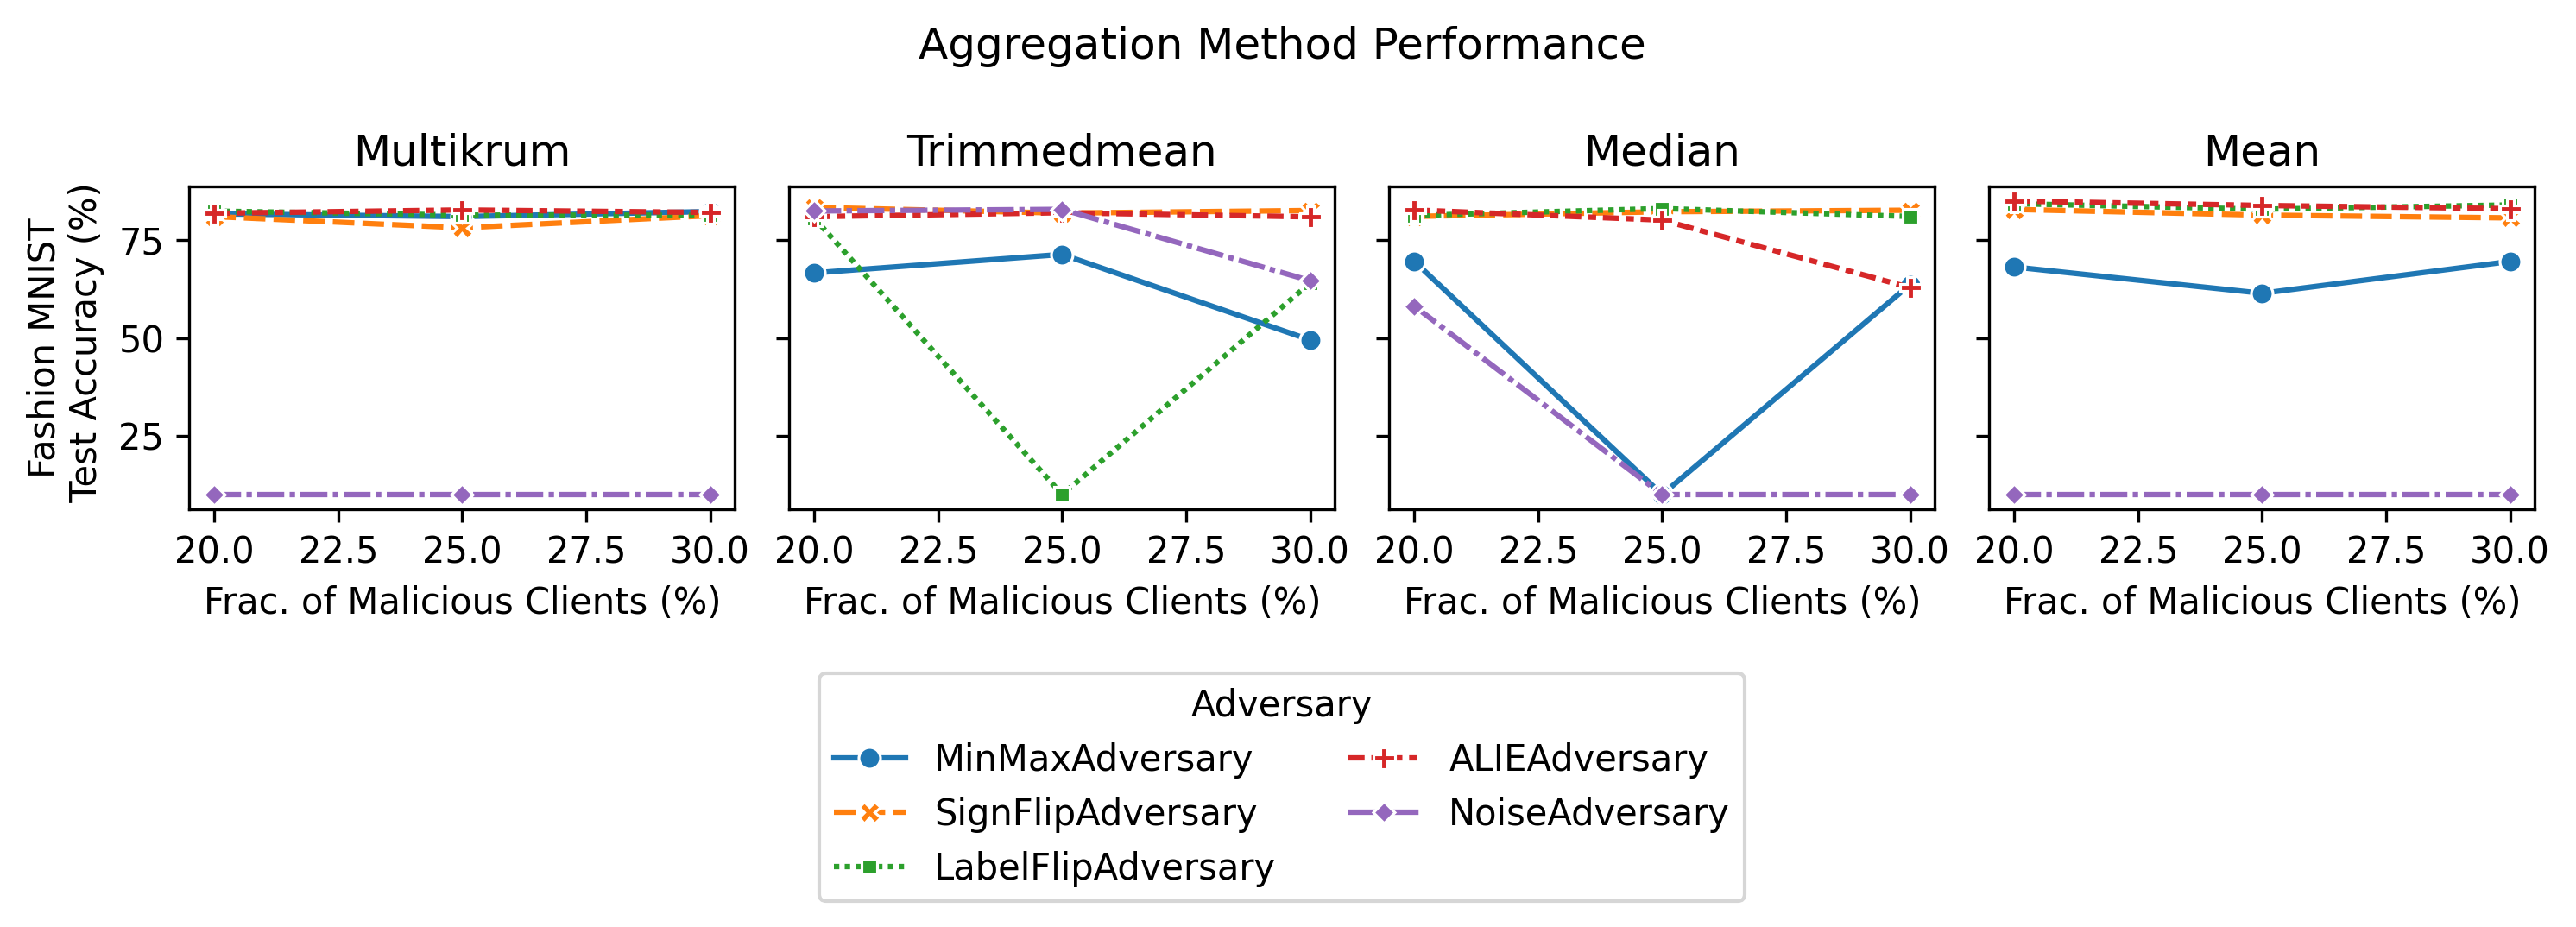

In [142]:
defenses = results_df["server_config.aggregator.type"].unique()

fig, ax = plt.subplots(1, len(defenses), figsize=(10, 2.5), dpi=300, sharex=True, sharey=True)
for i, defense in enumerate(defenses):
    defense_results = results_df[results_df["server_config.aggregator.type"] == defense]
    defense_results["frac_malicious_clients"] = 100 * defense_results["num_malicious_clients"] \
                                                / defense_results["dataset_config.num_clients"]
    defense_results["acc_top_1_pct"] = 100 * defense_results["acc_top_1"]
    sns.lineplot(
        data=defense_results,
        x="frac_malicious_clients",
        y="acc_top_1_pct",
        style="adversary_config.type",
        hue="adversary_config.type",
        ax=ax[i],
        markers=True
    )
    ax[i].set_title(defense)
    ax[i].set_xlabel("Frac. of Malicious Clients (%)")
    ax[i].set_ylabel("Fashion MNIST\n Test Accuracy (%)")

    handles, labels = ax[i].get_legend_handles_labels()
    labels = [l.split(".")[-1] for l in labels]
    ax[i].get_legend().remove()

    
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.4), ncols=2, fancybox=True, title="Adversary")
fig.suptitle("Aggregation Method Performance")
plt.tight_layout()

fig.savefig("figures/20250421_fedsgd_cnn_fashion_mnist.pdf")